## Importing and Unzipping Tiny Imagenet dataset

In [0]:
# !ls
# !rm -rf  weights_1
!ls
!mkdir weights_1

sample_data  tiny-imagenet-200	tiny-imagenet-200.zip  weights_1
mkdir: cannot create directory ‘weights_1’: File exists


In [0]:
## Download the dataset and unzip it everytime the session crashes.
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

--2019-04-09 09:07:49--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  20.2MB/s    in 15s     

2019-04-09 09:08:04 (16.3 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [0]:
## Skip the unzip if unzipped dataset is already present in the directory.
!ls
!unzip -qq 'tiny-imagenet-200.zip'
!ls

sample_data  tiny-imagenet-200	tiny-imagenet-200.zip  weights_1
replace tiny-imagenet-200/words.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: All
All
sample_data  tiny-imagenet-200	tiny-imagenet-200.zip  weights_1


In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib  inline
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [0]:
val_data = pd.read_csv('./tiny-imagenet-200/val/val_annotations.txt', sep='\t', header=None, names=['File', 'Class', 'X', 'Y', 'H', 'W'])
val_data.drop(['X', 'Y', 'H', 'W'], axis=1, inplace=True)
val_data.head(3)

,File,Class
0,val_0.JPEG,n03444034
1,val_1.JPEG,n04067472
2,val_2.JPEG,n04070727


In [0]:
!ls

sample_data  tiny-imagenet-200	tiny-imagenet-200.zip  weights_1


In [0]:
# Use Augmentaion parameters as required.
# train_datagen = ImageDataGenerator(
#     rescale= 1./255,
#     zoom_range = 0.2,
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True,
#     shear_range=0.2,
#     fill_mode='nearest'
#     )

train_datagen = ImageDataGenerator(rescale= 1./255,
                               rotation_range=40,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.1,
                               horizontal_flip=True,
                               fill_mode='nearest',
                               data_format='channels_last',
                               brightness_range=[0.5, 1.2])


valid_datagen = ImageDataGenerator(rescale=1./255,rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)
# valid_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory( r'./tiny-imagenet-200/train/', target_size=(64, 64), color_mode='rgb', 
                                                    batch_size=1024, class_mode='categorical', shuffle=True, interpolation='bicubic')

validation_generator = valid_datagen.flow_from_dataframe(val_data, directory='./tiny-imagenet-200/val/images/', x_col='File', y_col='Class', target_size=(64, 64),
                                                    color_mode='rgb', class_mode='categorical', batch_size=1024, shuffle=True,interpolation='bicubic')

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.


In [0]:
x_batch, y_val_batch = next(train_generator)
x_batch.shape

(1024, 64, 64, 3)

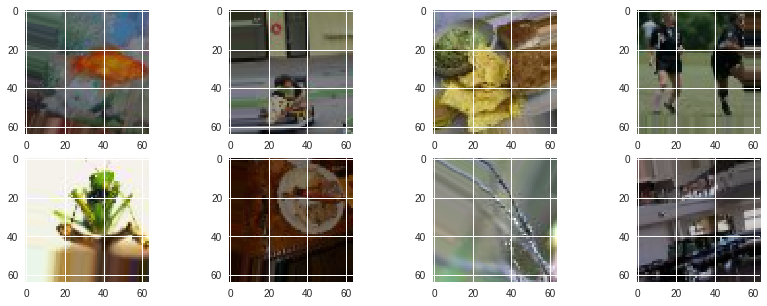

In [0]:
# Plot Generator images.

fig = plt.figure(figsize=(14, 5))

for i in range(8):
    sub = fig.add_subplot(2, 4, i + 1)
    sub.imshow(x_batch[i,:,:], interpolation='nearest')

##Resnet 

In [0]:
from __future__ import division

import six
from keras.models import Model
from keras.layers import (
    Input,
    Activation,
    Dense,
    Flatten
)
from keras.layers.convolutional import (
    Conv2D,
    MaxPooling2D,
    AveragePooling2D
)

from keras.layers import GlobalAveragePooling2D
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K


In [0]:
def _bn_relu(input):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)


def _conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu block
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        conv = Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(input)
        return _bn_relu(conv)

    return f


def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv block.
    This is an improved scheme proposed in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(activation)

    return f


def _shortcut(input, residual):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input)

    return add([shortcut, residual])


def _residual_block(block_function, filters, repetitions, is_first_layer=False):
    """Builds a residual block with repeating bottleneck blocks.
    """
    def f(input):
        for i in range(repetitions):
            init_strides = (1, 1)
            if i == 0 and not is_first_layer:
                init_strides = (2, 2)
            input = block_function(filters=filters, init_strides=init_strides,
                                   is_first_block_of_first_layer=(is_first_layer and i == 0))(input)
        return input

    return f


def basic_block(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv2D(filters=filters, kernel_size=(3, 3),
                           strides=init_strides,
                           padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=l2(1e-4))(input)
        else:
            conv1 = _bn_relu_conv(filters=filters, kernel_size=(3, 3),
                                  strides=init_strides)(input)

        residual = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv1)
        return _shortcut(input, residual)

    return f


def bottleneck(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Bottleneck architecture for > 34 layer resnet.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    Returns:
        A final conv layer of filters * 4
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = Conv2D(filters=filters, kernel_size=(1, 1),
                              strides=init_strides,
                              padding="same",
                              kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-4))(input)
        else:
            conv_1_1 = _bn_relu_conv(filters=filters, kernel_size=(1, 1),
                                     strides=init_strides)(input)

        conv_3_3 = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv_1_1)
        residual = _bn_relu_conv(filters=filters * 4, kernel_size=(1, 1))(conv_3_3)
        return _shortcut(input, residual)

    return f


def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    if K.image_dim_ordering() == 'tf':
        ROW_AXIS = 1
        COL_AXIS = 2
        CHANNEL_AXIS = 3
    else:
        CHANNEL_AXIS = 1
        ROW_AXIS = 2
        COL_AXIS = 3


def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier

###Resnet Builder

In [0]:

class ResnetBuilder(object):
    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions):
        """Builds a custom ResNet like architecture.
        Args:
            input_shape: The input shape in the form (nb_channels, nb_rows, nb_cols)
            num_outputs: The number of outputs at final softmax layer
            block_fn: The block function to use. This is either `basic_block` or `bottleneck`.
                The original paper used basic_block for layers < 50
            repetitions: Number of repetitions of various block units.
                At each block unit, the number of filters are doubled and the input size is halved
        Returns:
            The keras `Model`.
        """
        _handle_dim_ordering()
        if len(input_shape) != 3:
            raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

        # Permute dimension order if necessary
        if K.image_dim_ordering() == 'tf':
            input_shape = (input_shape[1], input_shape[2], input_shape[0])

        # Load function from str if needed.
        block_fn = _get_block(block_fn)

        input = Input(shape=input_shape)
        conv1 = _conv_bn_relu(filters=64, kernel_size=(7, 7), strides=(2, 2))(input)
        pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(conv1)

        block = pool1
        filters = 64
        for i, r in enumerate(repetitions):
            block = _residual_block(block_fn, filters=filters, repetitions=r, is_first_layer=(i == 0))(block)
            filters *= 2

        # Last activation
        block = _bn_relu(block)

        # Classifier block
        block_shape = K.int_shape(block)
        pool2 = AveragePooling2D(pool_size=(block_shape[ROW_AXIS], block_shape[COL_AXIS]),
                                 strides=(1, 1))(block)
        
        convPointwise = Conv2D(200, (1,1), padding='same', name ='conv_16', use_bias=False)(pool2)
        gpa = GlobalAveragePooling2D()(convPointwise)       
        predictions = Activation('softmax')(gpa)

#         flatten1 = Flatten()(pool2)
#         dense = Dense(units=num_outputs, kernel_initializer="he_normal",
#                       activation="softmax")(flatten1)

        model = Model(inputs=input, outputs=predictions)
        return model

    @staticmethod
    def build_resnet_18(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [2, 2, 2, 2])

    @staticmethod
    def build_resnet_34(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_50(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_101(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 23, 3])

    @staticmethod
    def build_resnet_152(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 8, 36, 3])

In [0]:
# input image dimensions
img_rows, img_cols = 64, 64
# The e images are RGB.
img_channels = 3
nb_classes = 200

##Cyclic Learning rate callback


In [0]:
from keras.callbacks import *

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

import tensorflow as tf
from tensorflow import keras


# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend

from keras import backend as k
tf.__version__

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.))
k.tensorflow_backend.set_session(tf.Session(config=config))




In [0]:
from keras.callbacks import *

from keras.optimizers import Adam, SGD


# Returns a short sequential model
def create_model():
  model = ResnetBuilder.build_resnet_34((img_channels, img_rows, img_cols), nb_classes)
  model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
  return model


# Create a basic model instance
model = create_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 32, 32, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_34 (BatchNo (None, 32, 32, 64)   256         conv2d_37[0][0]                  
__________________________________________________________________________________________________
activation_35 (Activation)      (None, 32, 32, 64)   0           batch_normalization_34[0][0]     
__________________________________________________________________________________________________
max_poolin

In [0]:
import timeit

checkpoint_path = "weights_1/cp-{epoch:04d}.hdf5"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1, save_weights_only=True,
    # Save weights, every 5-epochs.
    period=5)

model1 = create_model()
model1.save_weights(checkpoint_path.format(epoch=0))

startTime = timeit.default_timer()
# clr = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
# clr_triangular = CyclicLR(scale_fn=clr, scale_mode='cycle')


clr_triangular = CyclicLR(mode='exp_range', gamma=0.99994)


model1.fit_generator(train_generator, epochs=250, steps_per_epoch=100000//3200, validation_steps=10000//3200, validation_data=validation_generator, callbacks=[cp_callback, clr_triangular], verbose=1)

elapsedTime = timeit.default_timer() - startTime
print("Time taken for the Network to train : ",elapsedTime)


Instructions for updating:
Use tf.cast instead.
Epoch 1/250
31/31 [==============================] - 107s 3s/step - loss: 6.5426 - acc: 0.0347 - val_loss: 6.4443 - val_acc: 0.0339
Epoch 2/250
31/31 [==============================] - 85s 3s/step - loss: 5.7745 - acc: 0.0697 - val_loss: 5.7205 - val_acc: 0.0632
Epoch 3/250
31/31 [==============================] - 86s 3s/step - loss: 5.2871 - acc: 0.0946 - val_loss: 5.5166 - val_acc: 0.0622
Epoch 4/250
31/31 [==============================] - 88s 3s/step - loss: 4.9501 - acc: 0.1159 - val_loss: 5.2321 - val_acc: 0.0717
Epoch 5/250
31/31 [==============================] - 85s 3s/step - loss: 4.7543 - acc: 0.1309 - val_loss: 4.7402 - val_acc: 0.1377

Epoch 00005: saving model to weights_1/cp-0005.hdf5
Epoch 6/250
31/31 [==============================] - 86s 3s/step - loss: 4.6139 - acc: 0.1441 - val_loss: 4.8307 - val_acc: 0.1162
Epoch 7/250
31/31 [==============================] - 85s 3s/step - loss: 4.4503 - acc: 0.1613 - val_loss: 4.7391

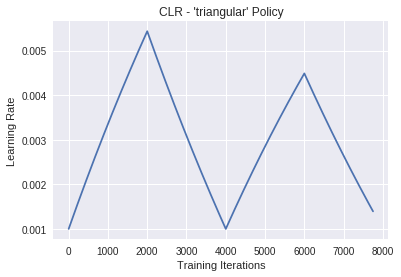

In [0]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - 'triangular' Policy")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

In [0]:
!ls {checkpoint_dir}

cp-0000.hdf5  cp-0055.hdf5  cp-0110.hdf5  cp-0165.hdf5	cp-0220.hdf5
cp-0005.hdf5  cp-0060.hdf5  cp-0115.hdf5  cp-0170.hdf5	cp-0225.hdf5
cp-0010.hdf5  cp-0065.hdf5  cp-0120.hdf5  cp-0175.hdf5	cp-0230.hdf5
cp-0015.hdf5  cp-0070.hdf5  cp-0125.hdf5  cp-0180.hdf5	cp-0235.hdf5
cp-0020.hdf5  cp-0075.hdf5  cp-0130.hdf5  cp-0185.hdf5	cp-0240.hdf5
cp-0025.hdf5  cp-0080.hdf5  cp-0135.hdf5  cp-0190.hdf5	cp-0245.hdf5
cp-0030.hdf5  cp-0085.hdf5  cp-0140.hdf5  cp-0195.hdf5	cp-0250.hdf5
cp-0035.hdf5  cp-0090.hdf5  cp-0145.hdf5  cp-0200.hdf5
cp-0040.hdf5  cp-0095.hdf5  cp-0150.hdf5  cp-0205.hdf5
cp-0045.hdf5  cp-0100.hdf5  cp-0155.hdf5  cp-0210.hdf5
cp-0050.hdf5  cp-0105.hdf5  cp-0160.hdf5  cp-0215.hdf5


In [0]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

In [0]:
model = create_model()

scores = model.evaluate_generator(validation_generator, steps=10000//512)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))


Baseline Error: 99.54%


In [0]:
model.load_weights("weights_1/cp-0250.hdf5")
loss, acc = model.evaluate_generator(validation_generator, steps=10000//512)
# print(scores)
print("Baseline Error: %.2f%%" % (100-acc*100))
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

Baseline Error: 55.68%
Restored model, accuracy: 44.32%


In [0]:
# model.compile(optimizer=tf.train.AdamOptimizer(learning_rate=lr), loss= tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [0]:
# with tf.variable_scope(tf.get_variable_scope(), resuse=tf.AUTO_REUSE):
#   model.fit_generator(aug_generator,validation_data = validation_generator, epochs=50, verbose =1)
  